In [5]:
from scipy.io import loadmat
from netCDF4 import Dataset
import numpy as np
import gsw



In [48]:
import scipy.sparse

#Units of "per year" for the transport matrix
base_transport = loadmat("OCIM2_48L_base_transport.mat")
#filter out the 'exit flux'
pos_base_tr_mat = base_transport['TR'].multiply(base_transport['TR'] > 0)
#normalize to get fractional contributions. Row is dest, col is source
transition_prob_mat = scipy.sparse.diags(1.0/np.asarray(np.sum(pos_base_tr_mat, axis=1)).flatten()) @ pos_base_tr_mat

In [6]:
data = Dataset("OCIM2_48L_base_data.nc")
tridx_to_fullgrid_idxs = np.nonzero(data.variables['ocnmask'][:].data)

In [8]:
list(data.variables.keys())

['ocnmask',
 'tlat',
 'tlon',
 'tz',
 'ulat',
 'ulon',
 'wz',
 'vol',
 'area',
 'kappa_para',
 'kappa_perp',
 'ptemp',
 'salt',
 'Delta14C',
 'del3He',
 'year_cfc11',
 'year_cfc12',
 'cfc11',
 'cfc12',
 'heatflux',
 'saltflux',
 'mld',
 'uvel',
 'vvel',
 'wvel',
 'ssh',
 'mantle_3he_flux']

In [25]:
ocnmask = data.variables['ocnmask'][:].data==1.0
ulat = data.variables['ulon'][:].data #latlon are swapped in file
ulon = data.variables['ulat'][:].data #latlon are swapped in file
wz = data.variables['wz'][:].data
salt = data.variables['salt'][:].data #units of psu means 'practical' sal?
ptemp = data.variables['ptemp'][:].data #ptempt wrt surface?
ssh = data.variables['ssh'][:].data #reference pressure? assuming ~0 dbar

In [191]:
ulat_ocnvec = ulat.ravel()[ocnmask.ravel()]
ulon_ocnvec = ulon.ravel()[ocnmask.ravel()]
#convert ulon to have negative longitudes
ulon_ocnvec = ulon_ocnvec*(ulon_ocnvec <= 180) + (-(360-ulon_ocnvec)*(ulon_ocnvec > 180))

depth_ocnvec = wz.ravel()[ocnmask.ravel()]

#z is expected to be negative in the ocean
#gives pressure in dbar
#removing geo_strf_dyn_height still gives stuff
# that's pretty correlated
p_ocnvec = gsw.p_from_z(
    z=-depth_ocnvec,
    lat=ulat_ocnvec,
    geo_strf_dyn_height=np.tile(ssh[None,:,:], (48,1,1)).ravel()[ocnmask.ravel()])

#absolute salinity
absal_ocnvec = gsw.SA_from_SP(
    SP=salt.ravel()[ocnmask.ravel()],
    p=p_ocnvec,
    lon=ulon_ocnvec,
    lat=ulat_ocnvec)

ctemp_ocnvec = gsw.CT_from_pt(
    SA=absal_ocnvec,
    pt=ptemp.ravel()[ocnmask.ravel()]) #assumes 0 dbar for pt

sig0_ocnvec = gsw.sigma0(SA=absal_ocnvec,CT=ctemp_ocnvec)
sig2_ocnvec = gsw.sigma2(SA=absal_ocnvec,CT=ctemp_ocnvec)
sig4_ocnvec = gsw.sigma4(SA=absal_ocnvec,CT=ctemp_ocnvec)


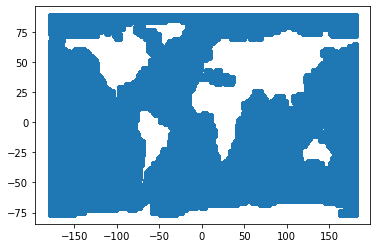

In [192]:
plt.scatter(ulon_ocnvec, ulat_ocnvec)

In [193]:
#copying filter conditions from
# https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/8aba68bf38940ffa7bc84afd7cedc5ac4380ecd2/GP15_Defining_Watermass_Subtypes.ipynb#scrollTo=h5hNQdcE2tnn

def get_nonzero_idxs(lat_min, lat_max,
                     lon_min, lon_max,
                     sig0_min=0, sig0_max=np.inf, 
                     sig2_min=0, sig2_max=np.inf,
                     sig4_min=0, sig4_max=np.inf):
    
    #need to subtract 180 cos ulon_ocnvec goes from 0 to 360
    nonzero_idxs = np.nonzero(
        (ulat_ocnvec >= lat_min)*(ulat_ocnvec <= lat_max)
       *((ulon_ocnvec) >= lon_min)*((ulon_ocnvec) <= lon_max)
       *(sig0_ocnvec >= sig0_min)*(sig0_ocnvec <= sig0_max)
       *(sig2_ocnvec >= sig2_min)*(sig2_ocnvec <= sig2_max)
       *(sig4_ocnvec >= sig4_min)*(sig4_ocnvec <= sig4_max)
    )[0]
    
    return nonzero_idxs

filter_conditions = {
    "AAIW": {"lat_min":-55.0, "lat_max":-43.0,
             "lon_min":-90, "lon_max":-80,
             "sig0_min":27.05, "sig0_max":27.15},
    "NPIW": {"lat_min":34.0, "lat_max":37.0, 
             "lon_min":140.0, "lon_max":153.0, 
             "sig0_min":26.5, "sig0_max":27.4, 
             #"ox_min":0, "ox_max":150.0, #TODO: think about this
             },
    "UCDW": {"lat_min":-49.5, "lat_max":-44.5, 
             "lon_min":-157.0, "lon_max":-147.0,
             "sig0_min":27.35, "sig0_max":27.75,
             },
    "LCDW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "sig0_min":27.79, "sig0_max":27.83,
             },
    "AABW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "sig4_min":46.04, "sig4_max":200,
             },
    "PDW": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.6, "sig0_max":200,
             "sig4_min":0, "sig4_max":45.88,
            },
    "EqIW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 26.86, "sig0_max": 27.3,
             },
    "PSUW": {"lat_min":50, "lat_max":58, 
             "lon_min":-155, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "ENPCW": {"lat_min":16, "lat_max":26, 
              "lon_min":-170, "lon_max":-140,
              "sig0_min": 25.29, "sig0_max": 26.86,
              },
    "ESSW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "SPCW": {"lat_min":-30, "lat_max":-20, 
             "lon_min":-152, "lon_max":-130, 
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "SPSTSW": {"lat_min":-20, "lat_max":-15, 
               "lon_min":-152, "lon_max":-142, 
               "sig0_min": 25.29, "sig0_max": 26.86,
              }
}

endmem_to_nonzeroidxs = dict([(the_key, set(get_nonzero_idxs(**val)))
                              for the_key,val in filter_conditions.items()])

In [194]:
import scipy.sparse
from collections import OrderedDict

class GetSteadyStateFracs(object):
    
    def __init__(self, base_transition_prob_mat, endmem_to_nonzeroidxs, main_endmem):
        
        rows_to_zeroout = np.ones(base_transition_prob_mat.shape[0])
        for nonzeroidxs in endmem_to_nonzeroidxs.values():
            for idx in nonzeroidxs:
                rows_to_zeroout[idx] = 0.0
        rowzerod_trprobmat = scipy.sparse.diags(rows_to_zeroout) @ base_transition_prob_mat
        
        self.endmem_to_trmatandinitvec = OrderedDict()
        self.endmem_to_lateststatevec = OrderedDict()
        
        self.trmat, self.initvec = self.get_trmat_and_initvec_for_endmem(
                            rowzerod_trprobmat=rowzerod_trprobmat,
                            endmem_nonzeroidxs=endmem_to_nonzeroidxs[main_endmem])
        self.lateststatevec = self.initvec
        self.total_timesteps = 0
        self.diff_from_prev = None
        
    @staticmethod
    def get_trmat_and_initvec_for_endmem(rowzerod_trprobmat, endmem_nonzeroidxs):
        new_rowzerod_trprobmat = rowzerod_trprobmat.copy()
        init_label_vec = np.zeros(rowzerod_trprobmat.shape[0])
        for idx in endmem_nonzeroidxs:
            new_rowzerod_trprobmat[idx,idx] = 1.0
            init_label_vec[idx] = 1.0
        return new_rowzerod_trprobmat, init_label_vec
    
    def take_step(self, num_timesteps=1):
        for i in range(num_timesteps):
            oldvec = self.lateststatevec
            self.lateststatevec = (self.trmat @ self.lateststatevec)
            self.diff_from_prev = self.lateststatevec - oldvec
            self.total_timesteps += 1
        print("convergence sum:",np.sum(np.abs(self.diff_from_prev)))
        print("convergence max:",np.max(np.abs(self.diff_from_prev)))
        
ss_fracs = GetSteadyStateFracs(base_transition_prob_mat=transition_prob_mat,
                               endmem_to_nonzeroidxs=endmem_to_nonzeroidxs,
                               main_endmem='NPIW')

In [195]:
#get the gp15 observations

In [203]:
ss_fracs.take_step(num_timesteps=2000)
print(ss_fracs.total_timesteps)

convergence sum: 0.34059131375475193
convergence max: 5.515532865968398e-05
4000


In [204]:
#get the cells corresponding to the gp15 cruise
gp15_idxs = get_nonzero_idxs(lon_min=-152, lon_max=-152, lat_min=-20, lat_max=60)

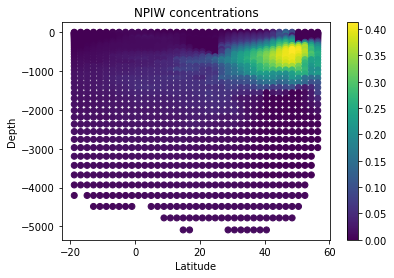

In [207]:
plt.scatter(
    ulat_ocnvec[gp15_idxs],
    -depth_ocnvec[gp15_idxs],
    c=ss_fracs.lateststatevec[gp15_idxs],
    #vmin=0.0, vmax=1.0
)
plt.ylabel("Depth")
plt.xlabel("Latitude")
plt.title("NPIW concentrations")
plt.colorbar()
plt.show()